## Analysis of CitiBike Data

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('data/weekly_bike_data.csv', header=0, index_col='time', parse_dates=True)

In [4]:
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df.head()

rides
time                      
2013-07-01 00:00:00     58
2013-07-01 01:00:00     26
2013-07-01 02:00:00     19
2013-07-01 03:00:00     10
2013-07-01 04:00:00      9

In [6]:
import seaborn; seaborn.set()

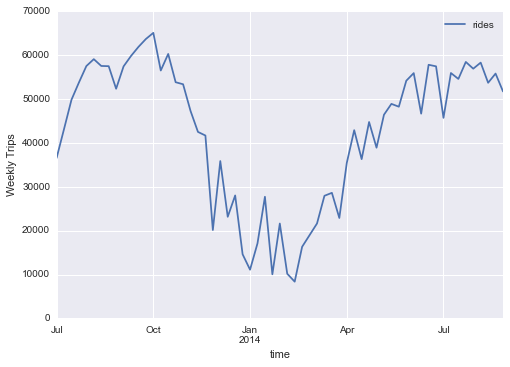

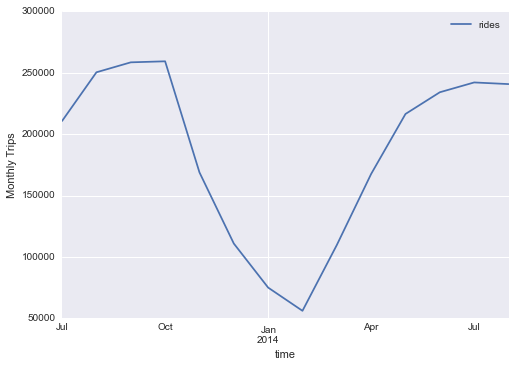

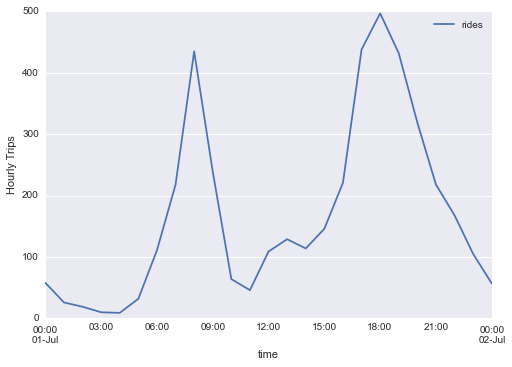

In [7]:
df.resample('W', how='sum').plot() # 'W'eekly summing the rides using resample method on our time series
plt.ylabel('Weekly Trips');

df.resample('M', how='sum').plot() # 'M'onthly summing the rides using resample method on our time series
plt.ylabel('Monthly Trips');

df[:25].resample('H', how='sum').plot() # 'H'ourly summing on a random day [:25] because 24 hours in a day
plt.ylabel('Hourly Trips');

In [8]:
daily = df.resample('D', how='sum')
weekly = df.resample('W', how='sum')

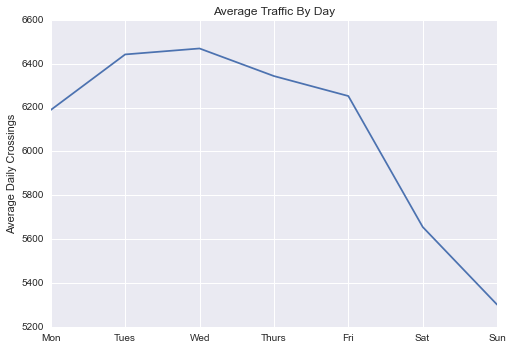

In [9]:
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
daily['dayofweek'] = daily['rides'].index.dayofweek
week = daily.groupby('dayofweek')['rides'].mean()
week.index = days

week.plot()
plt.title("Average Traffic By Day")
plt.ylabel("Average Daily Crossings");

In [10]:
def hours_of_daylight(date, axis=23.44, latitude=40.7127):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

In [11]:
daily['daylight'] = map(lambda x: hours_of_daylight(x), daily.index)
weekly['daylight'] = map(lambda x: hours_of_daylight(x), weekly.index)

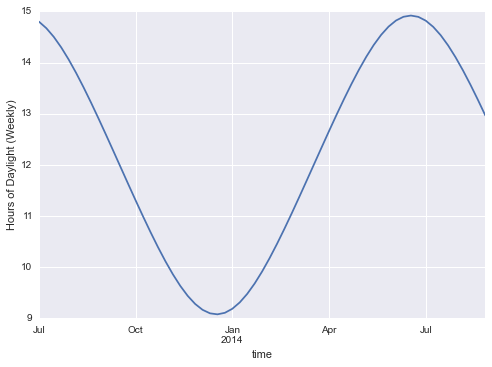

In [12]:
weekly.daylight.plot()
plt.ylabel('Hours of Daylight (Weekly)')

In [13]:
''' We want to plot # of rides against the amount of daylight. But we cannot include 2013 data because we do not have the 
entire year, so it will distort the graph '''

weekly2014 = df[df.index.year == 2014].resample('W', how='sum')

In [14]:
weekly2014['daylight'] = map(lambda x: hours_of_daylight(x), weekly2014.index)

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
X = weekly2014[['daylight']].as_matrix()
y = weekly2014[['rides']].as_matrix()

In [17]:
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
x_plot = np.linspace(8.5, 15.5)
y_pred = model.predict(x_plot.reshape(x_plot.shape[0], 1))

The equation for line of best fit is y = 8240.93 x + -66943.26


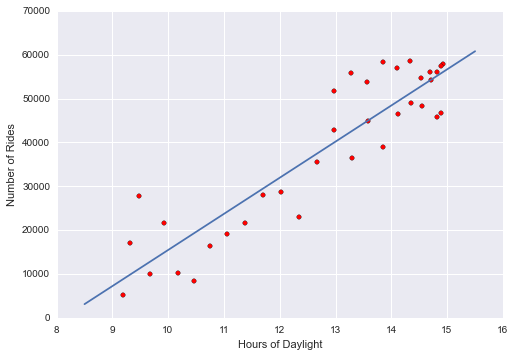

In [19]:
plt.scatter(weekly2014.daylight, weekly2014.rides, c="r")
plt.plot(x_plot, y_pred)
plt.xlabel('Hours of Daylight')
plt.ylabel('Number of Rides')
print 'The equation for line of best fit is y = %.2f x + %.2f' %(model.coef_, model.intercept_)

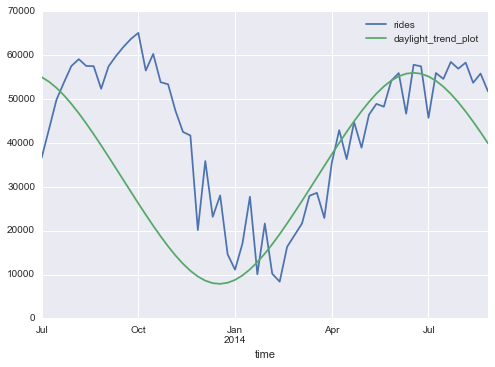

In [20]:
weekly['daylight_trend_plot'] = model.predict(weekly[['daylight']].as_matrix())
weekly[['rides', 'daylight_trend_plot']].plot()

## Pivoting the Data

In [21]:
pivoted = df.pivot_table(['rides'],
                         index = df.index.date,
                        columns = df.index.hour,
                        fill_value=0)

In [22]:
pivoted.head()

rides                                         ...                  \
              0   1   2   3   4   5    6    7    8    9  ...    14   15   16   
2013-07-01    58  26  19  10   9  32  111  218  435  239 ...   114  146  221   
2013-07-02    57  25  14  13   7  23  123  281  491  354 ...   277  278  399   
2013-07-03    59  31  18  13   7  27  126  248  507  401 ...   151  345  467   
2013-07-04    78  55  36  23  21  11   28   48   92  157 ...   467  469  479   
2013-07-05   105  57  38  20  13  13   56  127  235  238 ...   402  406  405   

                                               
             17   18   19   20   21   22   23  
2013-07-01  438  497  432  319  218  168  105  
2013-07-02  679  726  524  140  157  124  106  
2013-07-03  563  402  203  227  184  145  118  
2013-07-04  462  413  352  315  190  315  187  
2013-07-05  443  421  372  305  240  189  161  

[5 rows x 24 columns]

In [23]:
X = pivoted.values
print X.shape # 24 hours for 427 days

(427L, 24L)


## Priniciple Component Analysis

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(0.928)
X_transformed = pca.fit_transform(X)
print X_transformed.shape

(427L, 2L)


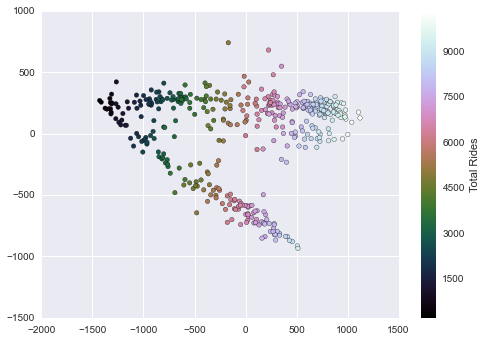

In [26]:
total_rides = X.sum(1) # count total rides for each day
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=total_rides,
            cmap='cubehelix')
plt.colorbar(label='Total Rides');

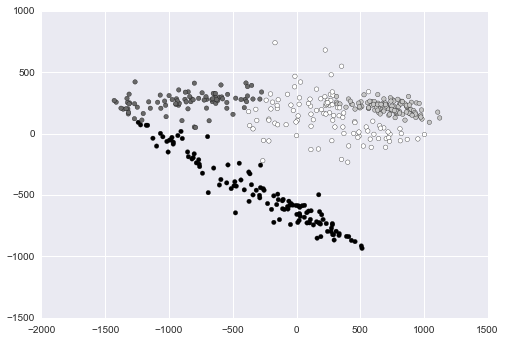

In [27]:
from sklearn.mixture import GMM
gmm = GMM(4, covariance_type='full', random_state=0)
gmm.fit(X_transformed)
cluster_label = gmm.predict(X_transformed)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=cluster_label);

In [28]:
def getCluster(cluster):
    if cluster == 1: # 1 is black , cluster order is 0-white, 1-black, 2- gray, etc...
        return 1
    else:
        return 0

In [29]:
pivoted['Cluster'] = cluster_label
df = df.join(pivoted['Cluster'], on=df.index.date)
df["Cluster_Cat"] = map(lambda x: getCluster(x), df.Cluster)
df.head()

rides  Cluster  Cluster_Cat
time                                            
2013-07-01 00:00:00     58        2            0
2013-07-01 01:00:00     26        2            0
2013-07-01 02:00:00     19        2            0
2013-07-01 03:00:00     10        2            0
2013-07-01 04:00:00      9        2            0

In [30]:
by_hour = df.groupby(['Cluster_Cat', df.index.time]).mean()
by_hour.head()

rides   Cluster
Cluster_Cat                              
0           00:00:00  63.487421  1.701258
            01:00:00  38.500000  1.701258
            02:00:00  24.185535  1.701258
            03:00:00  14.694969  1.701258
            04:00:00  11.871069  1.701258

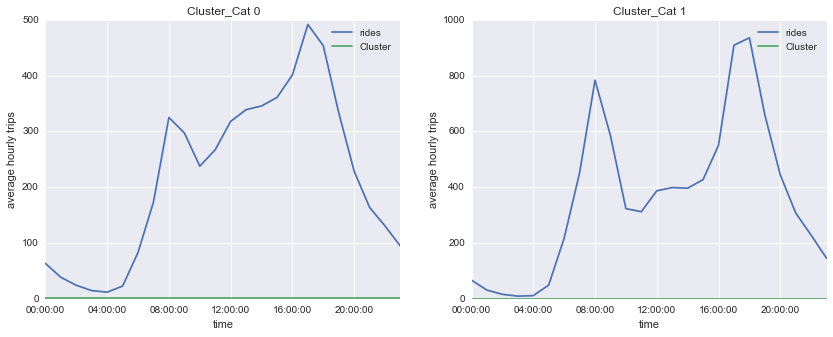

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    by_hour.ix[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title('Cluster_Cat {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')

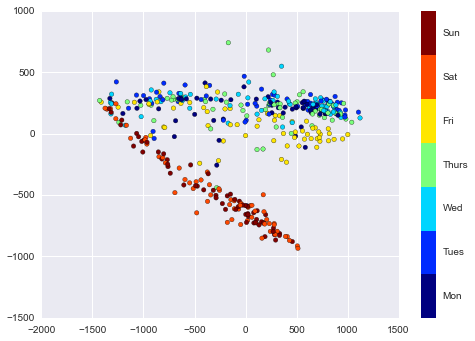

In [32]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);

Refer to https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/
for this analysis for Seattle, WA

Our data uses bike data from citigroup, which is a bike renting company. Our data is almost inverse of seattle workers. The weekends have peaks at 8 am and 5 pm bike rental starts but the weekdays have less so of a pattern.